# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [8]:
# One more import after logging in

from items import Item

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [9]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [13]:
import pickle

class SimpleItem:
    pass  # suficiente si el pickle guarda atributos en __dict__

with open('train.pkl', 'rb') as f:
    train = pickle.load(f)

with open('test.pkl', 'rb') as f:
    test = pickle.load(f)

# Ejemplo: ver un item
train[0].__dict__


{'title': 'OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW',
 'description': "As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K",
 'price': 120.0,
 'category': 'Human_Generated',
 'token_count': 193}

In [15]:
# Remind ourselves the training prompt

print(train[0].category)

Human_Generated


In [16]:
# Remind a test prompt

print(train[0].price)

120.0


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [43]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        n = min(self.size, len(self.data))
        for i in range(n):
            self.run_datapoint(i)


    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [18]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $25.00 Error: $630.00 SLE: 10.42 Item: MyCableMart 3.5mm Plug/Jack, 4 Conductor...
2: Guess: $115.00 Truth: $20.00 Error: $95.00 SLE: 2.92 Item: OtterBox + Pop Symmetry Series Case for ...
3: Guess: $26.00 Truth: $500.00 Error: $474.00 SLE: 8.53 Item: Dell XPS Desktop ( Intel Core i7 4790 (3...
4: Guess: $760.00 Truth: $400.00 Error: $360.00 SLE: 0.41 Item: Franklin Iron Works Sperry Industrial Br...
5: Guess: $282.00 Truth: $20.00 Error: $262.00 SLE: 6.76 Item: Avery Legal Dividers, Standard Collated ...
6: Guess: $251.00 Truth: $200.00 Error: $51.00 SLE: 0.05 Item: Moen 8346 Commercial Posi-Temp Pressure ...
7: Guess: $229.00 Truth: $300.00 Error: $71.00 SLE: 0.07 Item: Carlisle Versa Trail ATR All Terrain Rad...
8: Guess: $143.00 Truth: $100.00 Error: $43.00 SLE: 0.13 Item: SUNWAYFOTO 44mm Tripod Ball Head Arca Co...
9: Guess: $755.00 Truth: $150.00 Error: $605.00 SLE: 2.59 Item: NanoBeam AC 4 Units 5GHz High-Performanc...
10: Guess: $105.00 Truth: $250.00 E

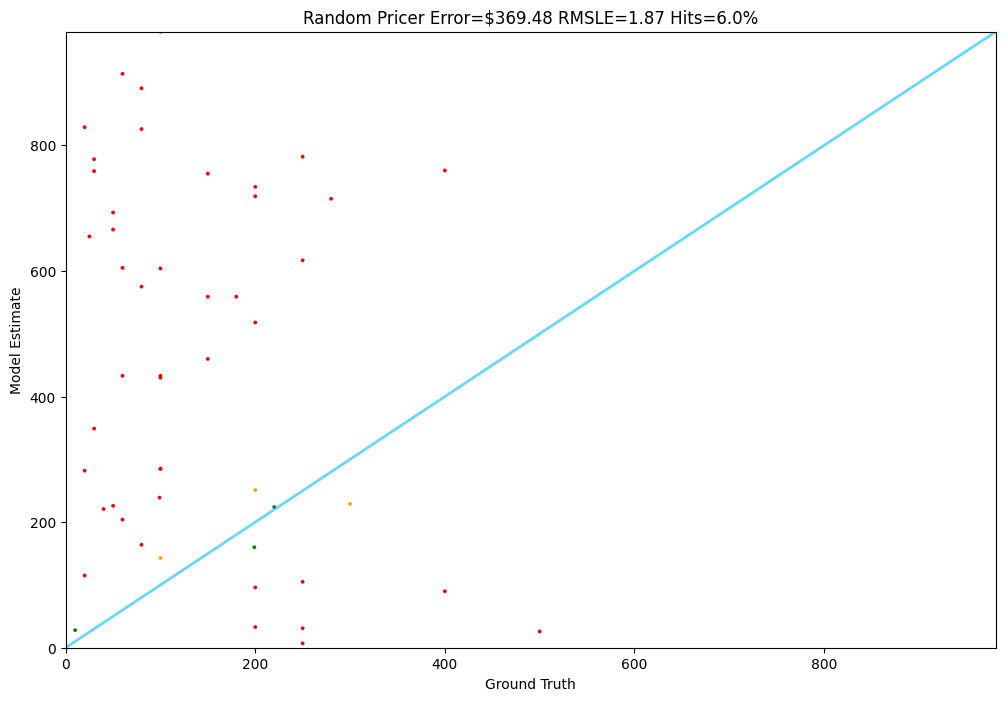

In [20]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester(random_pricer, data=test, size=len(test)).run()

In [21]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $129.97 Truth: $25.00 Error: $104.97 SLE: 2.61 Item: MyCableMart 3.5mm Plug/Jack, 4 Conductor...
2: Guess: $129.97 Truth: $20.00 Error: $109.97 SLE: 3.35 Item: OtterBox + Pop Symmetry Series Case for ...
3: Guess: $129.97 Truth: $500.00 Error: $370.03 SLE: 1.80 Item: Dell XPS Desktop ( Intel Core i7 4790 (3...
4: Guess: $129.97 Truth: $400.00 Error: $270.03 SLE: 1.25 Item: Franklin Iron Works Sperry Industrial Br...
5: Guess: $129.97 Truth: $20.00 Error: $109.97 SLE: 3.35 Item: Avery Legal Dividers, Standard Collated ...
6: Guess: $129.97 Truth: $200.00 Error: $70.03 SLE: 0.18 Item: Moen 8346 Commercial Posi-Temp Pressure ...
7: Guess: $129.97 Truth: $300.00 Error: $170.03 SLE: 0.69 Item: Carlisle Versa Trail ATR All Terrain Rad...
8: Guess: $129.97 Truth: $100.00 Error: $29.97 SLE: 0.07 Item: SUNWAYFOTO 44mm Tripod Ball Head Arca Co...
9: Guess: $129.97 Truth: $150.00 Error: $20.03 SLE: 0.02 Item: NanoBeam AC 4 Units 5GHz High-Performanc...
10: Guess: $129.97 Truth: $250.00 

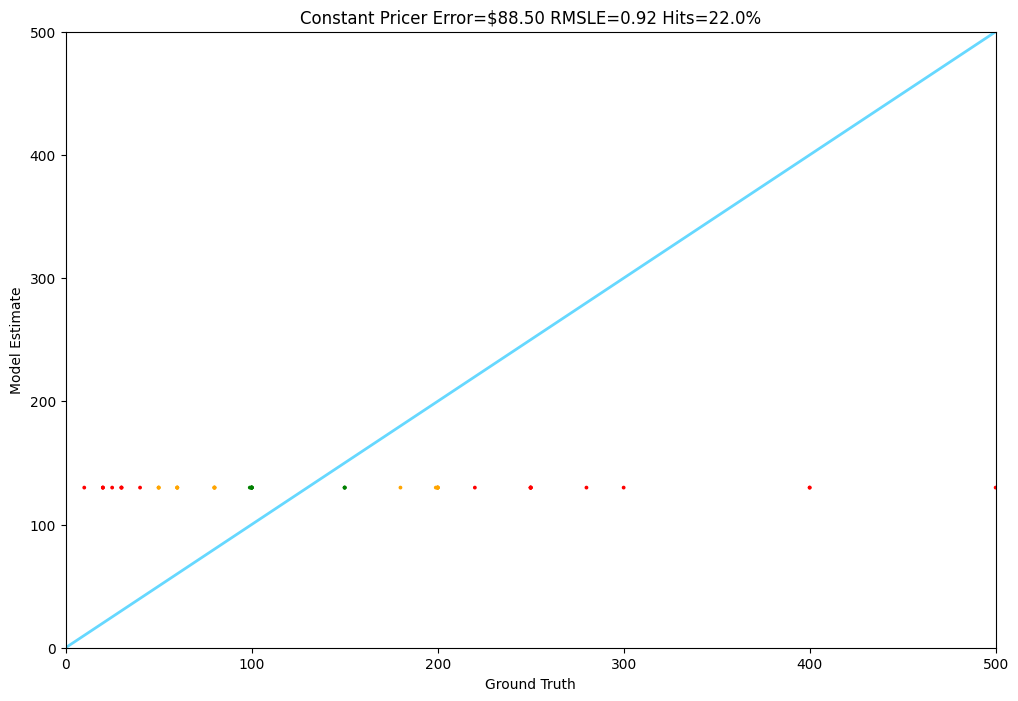

In [23]:
# Run our constant predictor
Tester(constant_pricer, data=test, size=len(test)).run()

In [27]:
train[0].description

"As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [ ]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [ ]:
train[0].features.keys()

In [ ]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

In [ ]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [ ]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [ ]:
average_weight = sum(weights)/len(weights)
average_weight

In [ ]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [ ]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [ ]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

In [ ]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [ ]:
def get_text_length(item):
    return len(item.test_prompt())

In [ ]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

In [28]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [29]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [ ]:
# Look at features in a training item
get_features(train[0])

In [ ]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [ ]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

In [ ]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

In [ ]:
# test it

Tester.test(linear_regression_pricer)

In [38]:
def _test_prompt(self):
    return f"{self.title}\n{self.description}"

SimpleItem.test_prompt = _test_prompt  # monkey patch
documents = [item.test_prompt() for item in train]

In [39]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [40]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [41]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

In [44]:
# test it

Tester.test(bow_lr_pricer)

1: Guess: $79.65 Truth: $25.00 Error: $54.65 SLE: 1.28 Item: MyCableMart 3.5mm Plug/Jack, 4 Conductor...
2: Guess: $79.31 Truth: $20.00 Error: $59.31 SLE: 1.80 Item: OtterBox + Pop Symmetry Series Case for ...
3: Guess: $302.70 Truth: $500.00 Error: $197.30 SLE: 0.25 Item: Dell XPS Desktop ( Intel Core i7 4790 (3...
4: Guess: $145.85 Truth: $400.00 Error: $254.15 SLE: 1.01 Item: Franklin Iron Works Sperry Industrial Br...
5: Guess: $101.17 Truth: $20.00 Error: $81.17 SLE: 2.50 Item: Avery Legal Dividers, Standard Collated ...
6: Guess: $105.33 Truth: $200.00 Error: $94.67 SLE: 0.41 Item: Moen 8346 Commercial Posi-Temp Pressure ...
7: Guess: $232.13 Truth: $300.00 Error: $67.87 SLE: 0.07 Item: Carlisle Versa Trail ATR All Terrain Rad...
8: Guess: $162.13 Truth: $100.00 Error: $62.13 SLE: 0.23 Item: SUNWAYFOTO 44mm Tripod Ball Head Arca Co...
9: Guess: $209.60 Truth: $150.00 Error: $59.60 SLE: 0.11 Item: NanoBeam AC 4 Units 5GHz High-Performanc...
10: Guess: $140.14 Truth: $250.00 Error:

In [45]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [46]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [47]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [48]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

In [49]:
Tester.test(word2vec_lr_pricer)

1: Guess: $346.28 Truth: $25.00 Error: $321.28 SLE: 6.72 Item: MyCableMart 3.5mm Plug/Jack, 4 Conductor...
2: Guess: $150.44 Truth: $20.00 Error: $130.44 SLE: 3.90 Item: OtterBox + Pop Symmetry Series Case for ...
3: Guess: $365.96 Truth: $500.00 Error: $134.04 SLE: 0.10 Item: Dell XPS Desktop ( Intel Core i7 4790 (3...
4: Guess: $114.83 Truth: $400.00 Error: $285.17 SLE: 1.54 Item: Franklin Iron Works Sperry Industrial Br...
5: Guess: $159.16 Truth: $20.00 Error: $139.16 SLE: 4.13 Item: Avery Legal Dividers, Standard Collated ...
6: Guess: $153.88 Truth: $200.00 Error: $46.12 SLE: 0.07 Item: Moen 8346 Commercial Posi-Temp Pressure ...
7: Guess: $116.61 Truth: $300.00 Error: $183.39 SLE: 0.88 Item: Carlisle Versa Trail ATR All Terrain Rad...
8: Guess: $137.65 Truth: $100.00 Error: $37.65 SLE: 0.10 Item: SUNWAYFOTO 44mm Tripod Ball Head Arca Co...
9: Guess: $246.69 Truth: $150.00 Error: $96.69 SLE: 0.24 Item: NanoBeam AC 4 Units 5GHz High-Performanc...
10: Guess: $51.88 Truth: $250.00 E

In [50]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,"epsilon epsilon: float, default=0.0Epsilon parameter in the epsilon-insensitive loss function. Notethat the value of this parameter depends on the scale of the targetvariable y. If unsure, set ``epsilon=0``.",0.0
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.",1.0
,"loss loss: {'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='epsilon_insensitive'Specifies the loss function. The epsilon-insensitive loss(standard SVR) is the L1 loss, while the squared epsilon-insensitiveloss ('squared_epsilon_insensitive') is the L2 loss.",'epsilon_insensitive'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes `[x_1, ...,x_n, intercept_scaling]`, i.e. a ""synthetic"" feature with a constantvalue equal to `intercept_scaling` is appended to the instance vector.The intercept becomes intercept_scaling * synthetic feature weight.Note that liblinear internally penalizes the intercept, treating itlike any other term in the feature vector. To reduce the impact of theregularization on the intercept, the `intercept_scaling` parameter canbe set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1.0
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features` and `loss`. If`n_samples` < `n_features` and optimizer supports chosen `loss`,then dual will be set to True, otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo random number generation for shuffling the data.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"max_iter max_iter: int, default=1000The maximum number of iterations to be run.",1000


In [51]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

In [52]:
Tester.test(svr_pricer)

1: Guess: $59.77 Truth: $25.00 Error: $34.77 SLE: 0.72 Item: MyCableMart 3.5mm Plug/Jack, 4 Conductor...
2: Guess: $60.18 Truth: $20.00 Error: $40.18 SLE: 1.14 Item: OtterBox + Pop Symmetry Series Case for ...
3: Guess: $59.60 Truth: $500.00 Error: $440.40 SLE: 4.46 Item: Dell XPS Desktop ( Intel Core i7 4790 (3...
4: Guess: $59.61 Truth: $400.00 Error: $340.39 SLE: 3.57 Item: Franklin Iron Works Sperry Industrial Br...
5: Guess: $60.16 Truth: $20.00 Error: $40.16 SLE: 1.14 Item: Avery Legal Dividers, Standard Collated ...
6: Guess: $59.90 Truth: $200.00 Error: $140.10 SLE: 1.43 Item: Moen 8346 Commercial Posi-Temp Pressure ...
7: Guess: $59.90 Truth: $300.00 Error: $240.10 SLE: 2.55 Item: Carlisle Versa Trail ATR All Terrain Rad...
8: Guess: $59.74 Truth: $100.00 Error: $40.26 SLE: 0.26 Item: SUNWAYFOTO 44mm Tripod Ball Head Arca Co...
9: Guess: $60.12 Truth: $150.00 Error: $89.88 SLE: 0.82 Item: NanoBeam AC 4 Units 5GHz High-Performanc...
10: Guess: $59.79 Truth: $250.00 Error: $190.

In [53]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [54]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [55]:
Tester.test(random_forest_pricer)

1: Guess: $121.68 Truth: $25.00 Error: $96.68 SLE: 2.41 Item: MyCableMart 3.5mm Plug/Jack, 4 Conductor...
2: Guess: $191.41 Truth: $20.00 Error: $171.41 SLE: 4.91 Item: OtterBox + Pop Symmetry Series Case for ...
3: Guess: $249.56 Truth: $500.00 Error: $250.44 SLE: 0.48 Item: Dell XPS Desktop ( Intel Core i7 4790 (3...
4: Guess: $213.77 Truth: $400.00 Error: $186.23 SLE: 0.39 Item: Franklin Iron Works Sperry Industrial Br...
5: Guess: $183.45 Truth: $20.00 Error: $163.45 SLE: 4.72 Item: Avery Legal Dividers, Standard Collated ...
6: Guess: $99.83 Truth: $200.00 Error: $100.17 SLE: 0.48 Item: Moen 8346 Commercial Posi-Temp Pressure ...
7: Guess: $97.73 Truth: $300.00 Error: $202.27 SLE: 1.24 Item: Carlisle Versa Trail ATR All Terrain Rad...
8: Guess: $144.08 Truth: $100.00 Error: $44.08 SLE: 0.13 Item: SUNWAYFOTO 44mm Tripod Ball Head Arca Co...
9: Guess: $177.38 Truth: $150.00 Error: $27.38 SLE: 0.03 Item: NanoBeam AC 4 Units 5GHz High-Performanc...
10: Guess: $106.41 Truth: $250.00 Er